In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pymc as pm
import arviz as az
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Loading in the data
! wget https://raw.githubusercontent.com/anfeng2/ace/main/pollution_data_year_county.csv
! wget https://raw.githubusercontent.com/anfeng2/ace/main/state_regions.csv
! wget https://raw.githubusercontent.com/anfeng2/ace/main/cdi_data_asthma.csv
! wget https://raw.githubusercontent.com/anfeng2/ace/main/adult_obesity_cleaned.csv
! wget https://raw.githubusercontent.com/anfeng2/ace/main/adolescent_obesity_cleaned.csv
! wget https://raw.githubusercontent.com/anfeng2/ace/main/state_poverty_median_income.csv
! wget https://raw.githubusercontent.com/anfeng2/ace/main/pollution_data_year_county.csv
! wget https://raw.githubusercontent.com/anfeng2/ace/main/cigarettes_2019.csv
! wget https://raw.githubusercontent.com/anfeng2/ace/main/disease_data_asthma.csv
! wget https://raw.githubusercontent.com/anfeng2/ace/main/glm_final_dataset.csv

--2024-05-05 20:06:55--  https://raw.githubusercontent.com/anfeng2/ace/main/pollution_data_year_county.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396246 (387K) [text/plain]
Saving to: ‘pollution_data_year_county.csv.2’

pollution_data_year 100%[===================>] 386.96K  --.-KB/s    in 0.04s   

2024-05-05 20:06:55 (10.8 MB/s) - ‘pollution_data_year_county.csv.2’ saved [396246/396246]

--2024-05-05 20:06:55--  https://raw.githubusercontent.com/anfeng2/ace/main/state_regions.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


# **Gathering Data**

### Data for EDA/Bayesian Hierarchical

We loaded in the asthma data and then filtered out for adults who are 18 years or older and only looked at data that was in 2014.

In [3]:
# Load in asthma data
asthma_data = pd.read_csv("cdi_data_asthma.csv")
cleaned_asthma = asthma_data[asthma_data['Question'] == 'Current asthma prevalence among adults aged >= 18 years']
cleaned_asthma = cleaned_asthma[(cleaned_asthma['YearStart'] == 2014) & (cleaned_asthma['YearEnd'] == 2014)]
cleaned_asthma = cleaned_asthma[cleaned_asthma['DataValueType'] == 'Crude Prevalence']
cleaned_asthma = cleaned_asthma[cleaned_asthma['StratificationCategory1'] == 'Overall']
cleaned_asthma.head(3)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
29335,2014,2014,NC,North Carolina,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Crude Prevalence,...,37,AST,AST1_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN
30191,2014,2014,AK,Alaska,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Crude Prevalence,...,2,AST,AST1_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN
31172,2014,2014,AL,Alabama,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Crude Prevalence,...,1,AST,AST1_1,CRDPREV,OVERALL,OVR,NaN,NaN,NaN,NaN


We loaded in the pollition data and then filtered only for the year 2014. We then grouped by state to calculate the state pollution means per state.

In [4]:
# Load in pollution data
pollution = pd.read_csv("pollution_data_year_county.csv")
pollution = pollution[pollution["year"] == 2014]
pollution_state_grouped = pollution.groupby("statefips").mean()
pollution_state_grouped.head(3)

,year,countyfips,ds_pm_pred
statefips,,,
1,2014.0,1067.000000,10.628984
4,2014.0,4013.866667,5.687440
5,2014.0,5075.000000,9.703796


We loaded in regions and then merged pollution and regions, so that we have PM2.5 levels for each region.

In [5]:
# Loaded in regions
regions = pd.read_csv("state_regions.csv")
pollution_with_regions = pd.merge(pollution, regions, left_on="statefips", right_on="FIPS Code")[["Region", "ds_pm_pred"]]
pollution_with_regions.head(3)

,Region,ds_pm_pred
0,Midwest,11.224554
1,Midwest,11.559470
2,Midwest,11.485285


### Data for GLMs

We loaded data on adult obesity, adolescent obseity, state poverty median income, pollution, cigarettes, and asthma and combined it into one dataframe to use in our GLM model later on.



In [6]:
adult_obesity = pd.read_csv('adult_obesity_cleaned.csv')
adult_obesity = adult_obesity.rename(columns = {"Value":"adult_obesity"})
adolescent_obesity = pd.read_csv("adolescent_obesity_cleaned.csv")
adolescent_obesity = adolescent_obesity.rename(columns = {"Value":"adolescent_obesity"})
merged = adult_obesity.merge(adolescent_obesity, on = "FIPS", how = "outer")
merged = merged.drop(columns = "Location_y")

state_poverty = pd.read_csv("state_poverty_median_income.csv")
state_poverty = state_poverty.drop(columns = "Postal Code")
state_poverty = state_poverty.rename(columns = {"State FIPS Code":"FIPS"})
further_merged = state_poverty.merge(merged, on = "FIPS", how = "outer")

pollution_data = pd.read_csv("pollution_data_year_county.csv")
pollution_data_2014 = pollution_data[pollution_data['year'] == 2014]
pollution_data_2014_state = pollution_data_2014.groupby("statefips").mean().drop(columns = ["year", "countyfips"]).reset_index()
pollution_data_2014_state = pollution_data_2014_state.rename(columns = {"statefips":"FIPS"})
even_further_merged = further_merged.merge(pollution_data_2014_state, on = "FIPS", how = "outer")

cigarettes = pd.read_csv("cigarettes_2019.csv")
cigarettes = cigarettes.rename(columns = {"Data_Value":"smoking_rate"})
even_even_further_merged = even_further_merged.merge(cigarettes, on = "FIPS", how = "outer")
even_even_further_merged = even_even_further_merged.drop(columns = ["Name", "LocationDesc"])
even_even_further_merged = even_even_further_merged.rename(columns = {"FIPS":"statefips",
                                                                      "Poverty Percent, All Ages":"poverty_rate_all_ages",
                                                                      "Poverty Percent, Age 0-17":"poverty_rate_0_to_17",
                                                                      "Median Household Income":"median_income",
                                                                      "Location_x":"district_name"})
even_even_further_merged = even_even_further_merged[["district_name", "statefips", "poverty_rate_all_ages", "poverty_rate_0_to_17",
                                                     "median_income", "district_name", "adult_obesity", "adolescent_obesity",
                                                     "ds_pm_pred", "smoking_rate"]]

asthma_data = pd.read_csv("disease_data_asthma.csv")
filtered_asthma = asthma_data[asthma_data['Question'] == 'Current asthma prevalence among adults aged >= 18 years']
filtered_asthma = filtered_asthma[(filtered_asthma['YearStart'] == 2014) & (filtered_asthma['YearEnd'] == 2014)]
filtered_asthma = filtered_asthma[filtered_asthma['DataValueType'] == 'Crude Prevalence']
filtered_asthma = filtered_asthma[filtered_asthma['StratificationCategory1'] == 'Overall']
filtered_asthma = filtered_asthma[['LocationID', 'DataValue', 'LocationDesc']]
filtered_asthma = filtered_asthma.rename(columns = {"LocationID":"statefips", "DataValue":"asthma_crude_prevalence"})
filtered_asthma = filtered_asthma.sort_values(by = "statefips")
last_merged = even_even_further_merged.merge(filtered_asthma, on = "statefips", how = "outer").drop(columns = "LocationDesc")
last_merged = last_merged.sort_values(by = "statefips")

region_data = pd.read_csv("state_regions.csv")
region_data = region_data.rename(columns = {"FIPS Code":"statefips", "Region":"region"})
last_last_merged = last_merged.merge(region_data, on = "statefips", how = "outer").drop(columns = ["State"])


# Remove supplemental codes for maritime areas (not of interest because no people there) and outlying territories
last_merged_filtered = last_last_merged[(last_last_merged['statefips'] <  57) & (last_merged['statefips'] > 0)]
last_merged_filtered.loc[9, "region"] = "Northeast" # Fill in region for DC
last_merged_filtered = last_merged_filtered.loc[:,~last_merged_filtered.columns.duplicated()].copy() # Remove duplicate district name column
# last_merged_filtered.to_csv('glm_final_dataset.csv')
last_merged_filtered.head(3)

,district_name,statefips,poverty_rate_all_ages,poverty_rate_0_to_17,median_income,adult_obesity,adolescent_obesity,ds_pm_pred,smoking_rate,asthma_crude_prevalence,region
1,Alabama,1,19.2,27.4,"42,917",33.5,17.1,10.628984,20.2,9.5,South
2,Alaska,2,11.4,15.5,"70,898",29.7,12.4,NaN,17.4,8.1,West
3,Arizona,4,18.2,25.6,"50,036",28.9,10.7,5.687440,14.9,9.6,West


# **EDA**

### Quantitative Variable: Histogram for State-level Asthma Crude Prevalence in 2014

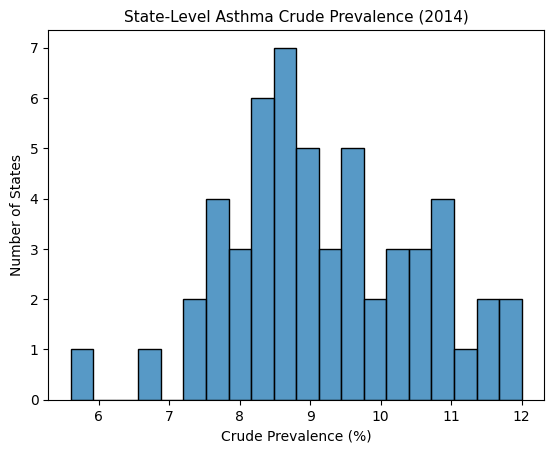

In [7]:
# Distribution of state-level asthma crude prevalence in 2014
sns.histplot(cleaned_asthma, x = "DataValue", bins = 20);
plt.title("State-Level Asthma Crude Prevalence (2014)", fontsize = 11);
plt.xlabel("Crude Prevalence (%)");
plt.ylabel("Number of States");

### Quantitative Variable: Histogram for State-level PM2.5 Concentrations in 2014

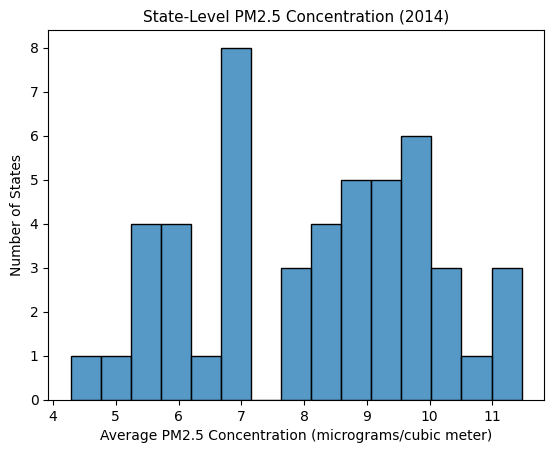

In [8]:
# Distribution of state-level PM2.5 concentrations in 2014
sns.histplot(pollution_state_grouped, x = "ds_pm_pred", bins = 15);
plt.title("State-Level PM2.5 Concentration (2014)", fontsize = 11);
plt.xlabel("Average PM2.5 Concentration (micrograms/cubic meter)");
plt.ylabel("Number of States");

### Categorical Variable: Violin Plots for State-level PM2.5 Concentration in 2014, Stratified on US Region

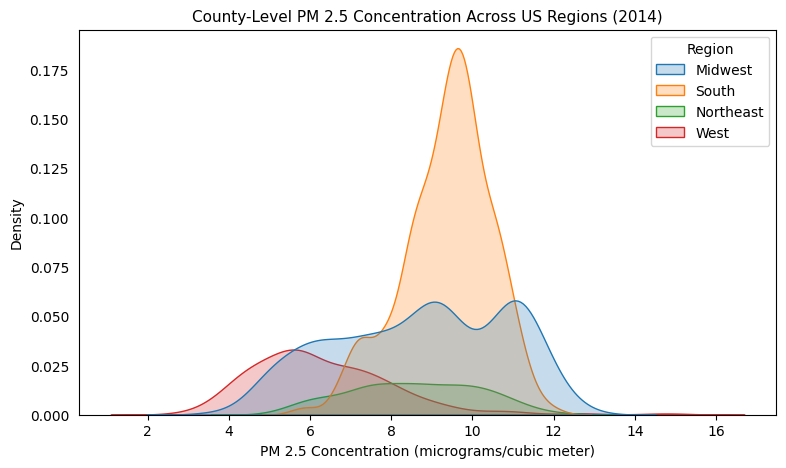

In [9]:
plt.rcParams['figure.figsize'] = (9,5);
sns.kdeplot(pollution_with_regions, x = "ds_pm_pred", hue = "Region", fill = True)
plt.title("County-Level PM 2.5 Concentration Across US Regions (2014)", fontsize = 11);
plt.xlabel("PM 2.5 Concentration (micrograms/cubic meter)");
plt.tick_params(left = False);

### Categorical Variable: Box Plots for State-level Asthma Crude Prevalence in 2014, Stratified on US Regions

In [10]:
asthma_with_regions = pd.merge(cleaned_asthma, regions, left_on="LocationDesc", right_on="State")[["Region", "DataValue"]]

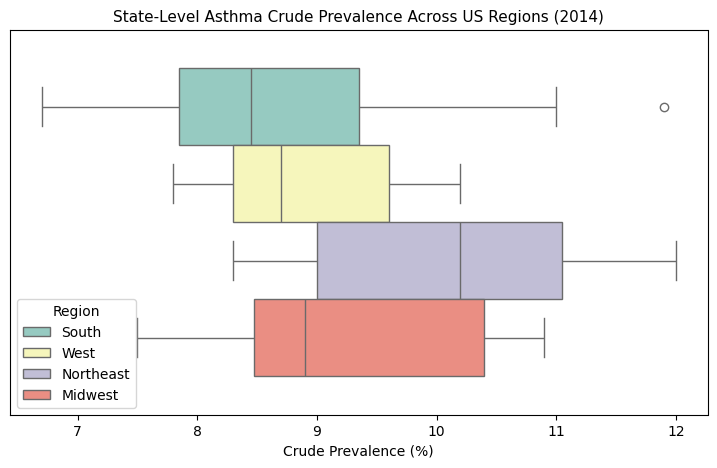

In [11]:
plt.rcParams['figure.figsize']=(9,5);
sns.boxplot(asthma_with_regions, x = 'DataValue', hue = 'Region', palette = "Set3");
plt.title("State-Level Asthma Crude Prevalence Across US Regions (2014)", fontsize = 11);
plt.xlabel("Crude Prevalence (%)");
plt.tick_params(left = False);

### Categorical Variable: KDE Plot for County-Level PM2.5 Concentration in Select States

In [12]:
pollution_big_states = pd.merge(pollution, regions, left_on="statefips", right_on="FIPS Code")
pollution_big_states = pollution_big_states[(pollution_big_states["State"]=="California") | (pollution_big_states["State"]=="New York") | (pollution_big_states["State"]=="Idaho")  | (pollution_big_states["State"]=="Minnesota")]

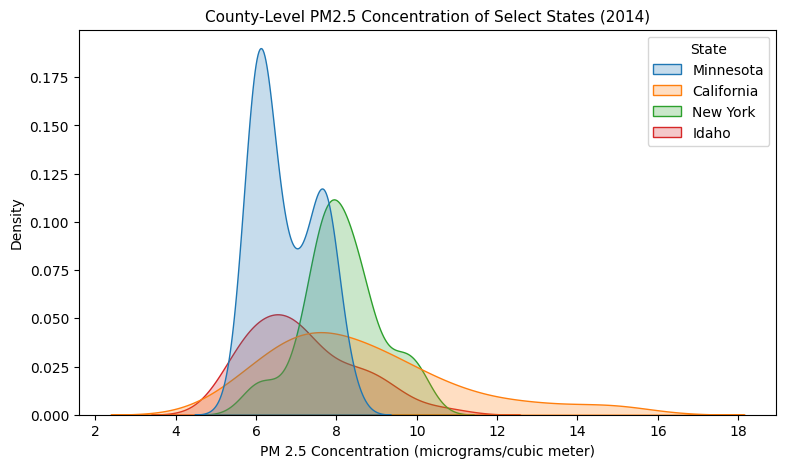

In [13]:
sns.kdeplot(pollution_big_states, x = "ds_pm_pred", hue = "State", fill = True);
plt.title("County-Level PM2.5 Concentration of Select States (2014)", fontsize = 11);
plt.xlabel("PM 2.5 Concentration (micrograms/cubic meter)");

### Quantitative Variable: Histogram for Asthma Emergency Department Visits Crude Rate Across States

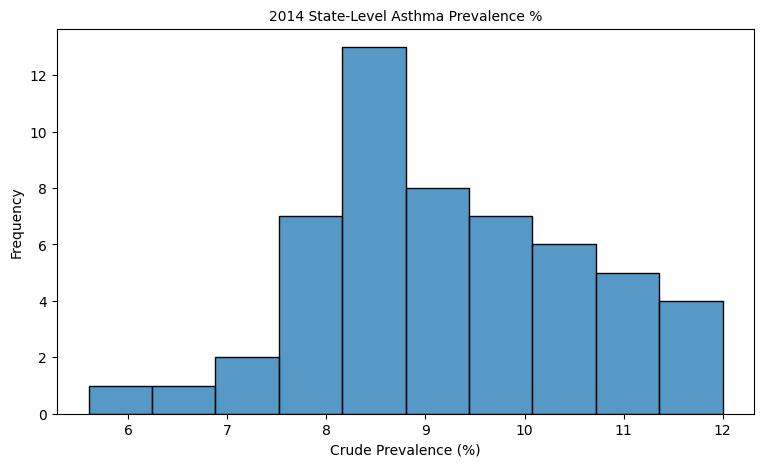

In [14]:
sns.histplot(cleaned_asthma['DataValue'], bins = 10)
plt.title("2014 State-Level Asthma Prevalence %", fontsize = 10)
plt.xlabel("Crude Prevalence (%)")
plt.ylabel("Frequency");

# **Bayesian Hierarchal**

Research Question: Given that we are using a Bayesian hierarchical model with a gamma hyperprior for region-level PM2.5 concentration means, and then a gamma prior for county-level PM2.5 concentrations, what meaningful conclusions can we draw about region-level differences in pollution?

In [15]:
pollution_with_regions

,Region,ds_pm_pred
0,Midwest,11.224554
1,Midwest,11.559470
2,Midwest,11.485285
3,Midwest,11.464069
4,Midwest,11.300511
...,...,...
3103,West,8.547217
3104,West,4.521123
3105,West,4.359456
3106,West,4.845443


In [16]:
alpha_hat, loc, beta_hat = stats.gamma.fit(pollution_with_regions['ds_pm_pred'], floc=0, fscale=1)
print(alpha_hat, beta_hat)

8.933869032934206 1


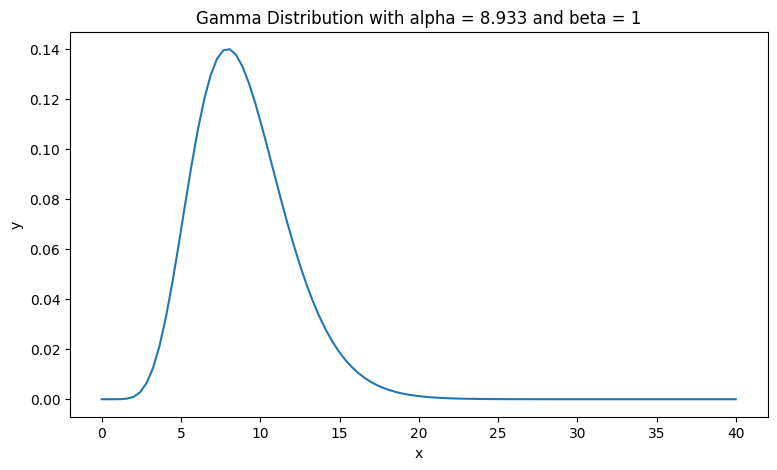

In [17]:
#define x-axis values
x = np.linspace(0, 40, 100)

#calculate pdf of Gamma distribution for each x-value
y = stats.gamma.pdf(x, a=8.93427493930105, scale=1)

#create plot of Gamma distribution
sns.lineplot(data=pd.DataFrame({'x': x, 'y':y}), x='x', y='y')
plt.title("Gamma Distribution with alpha = 8.933 and beta = 1");

In [18]:
alpha_eb, beta_eb = alpha_hat, beta_hat  # empirical bayes

In [19]:
num_regions = 4
regions = pollution_with_regions["Region"].unique()
with pm.Model() as model:
    # Your code for the random variables goes here
    mu = pm.Gamma('mu', alpha=alpha_eb, beta=beta_eb, shape=num_regions)
    sigma = pm.Uniform("sigma", lower=0, upper=15, shape=num_regions)

    region_alpha = (mu ** 2) / sigma
    region_beta = mu / sigma

    # for i in range(len(states)):
    y_1j= pm.Gamma('y_1j', alpha=region_alpha[0], beta=region_beta[0], observed=pollution_with_regions[pollution_with_regions['Region']==regions[0]]["ds_pm_pred"])
    y_2j= pm.Gamma('y_2j', alpha=region_alpha[1], beta=region_beta[1], observed=pollution_with_regions[pollution_with_regions['Region']==regions[1]]["ds_pm_pred"])
    y_3j= pm.Gamma('y_3j', alpha=region_alpha[2], beta=region_beta[2], observed=pollution_with_regions[pollution_with_regions['Region']==regions[2]]["ds_pm_pred"])
    y_4j= pm.Gamma('y_4j', alpha=region_alpha[3], beta=region_beta[3], observed=pollution_with_regions[pollution_with_regions['Region']==regions[3]]["ds_pm_pred"])

    # Don't change this line
    trace_d = pm.sample(2000, chains=2, tune=100, return_inferencedata=True)

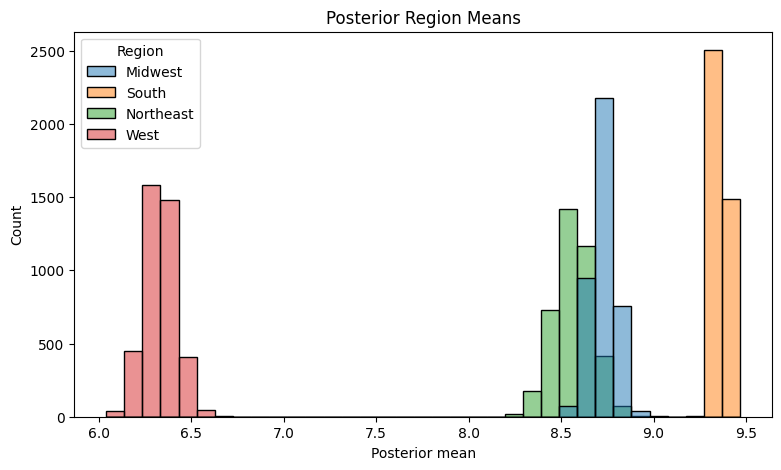

In [20]:
# You don't have to change
def plot_state_posterior_means(trace, state_names, **kwargs):
    """Shows distribution of posterior means from a PyMC trace.

    Args:
        trace: the result of pm.sample(...).
            Assumes the state-level means have been called 'mu'
        state_names: a list or array of state names
        **kwargs: any extra arguments are passed in to sns.histplot
    """
    num_state = len(state_names)
    mu_array = trace.posterior['mu'].values.reshape(-1, num_regions)
    means_wide = pd.DataFrame(mu_array, columns=state_names)
    means_long = pd.melt(means_wide, var_name='Region', value_name='Posterior mean')
    sns.histplot(means_long, x='Posterior mean', hue='Region')
    plt.title("Posterior Region Means");

plot_state_posterior_means(trace_d, regions)

In [21]:
print("Midwest posterior variance: "+str(np.var(trace_d.posterior["mu"].values.reshape(-1, 4)[:,0])))
print("South posterior variance: "+str(np.var(trace_d.posterior["mu"].values.reshape(-1, 4)[:,1])))
print("Northeast posterior variance: "+str(np.var(trace_d.posterior["mu"].values.reshape(-1, 4)[:,2])))
print("West posterior variance: "+str(np.var(trace_d.posterior["mu"].values.reshape(-1, 4)[:,3])))

Midwest posterior variance: 0.004463051663181907
South posterior variance: 0.0009535661115537963
Northeast posterior variance: 0.010869870868180245
West posterior variance: 0.006922733746194113


In [22]:
print("Midwest posterior mean: "+str(np.mean(trace_d.posterior["mu"].values.reshape(-1, 4)[:,0])))
print("South posterior mean: "+str(np.mean(trace_d.posterior["mu"].values.reshape(-1, 4)[:,1])))
print("Northeast posterior mean: "+str(np.mean(trace_d.posterior["mu"].values.reshape(-1, 4)[:,2])))
print("West posterior mean: "+str(np.mean(trace_d.posterior["mu"].values.reshape(-1, 4)[:,3])))

Midwest posterior mean: 8.728203020974794
South posterior mean: 9.360821949824686
Northeast posterior mean: 8.564836982613324
West posterior mean: 6.331198399105988


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


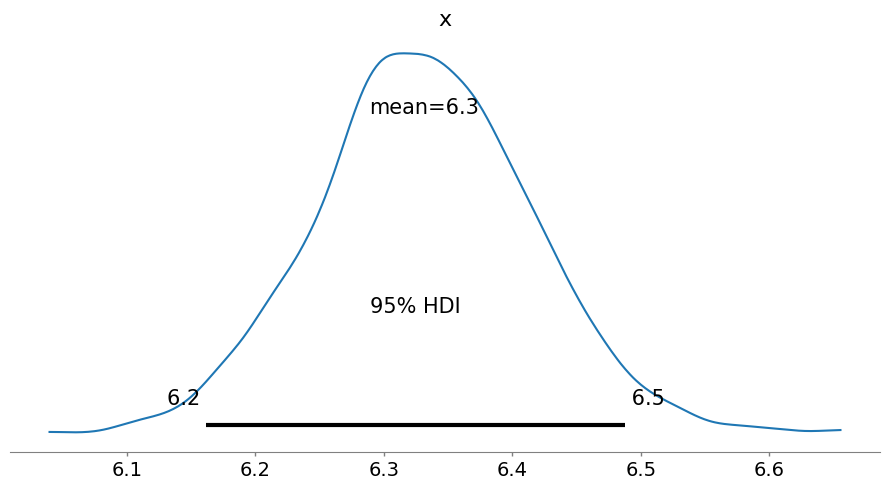

In [23]:
# Plotting 95% Credible Interval for the West's mean
az.plot_posterior(trace_d.posterior["mu"].values.reshape(-1, 4)[:,3], hdi_prob = 0.95)
plt.tight_layout()

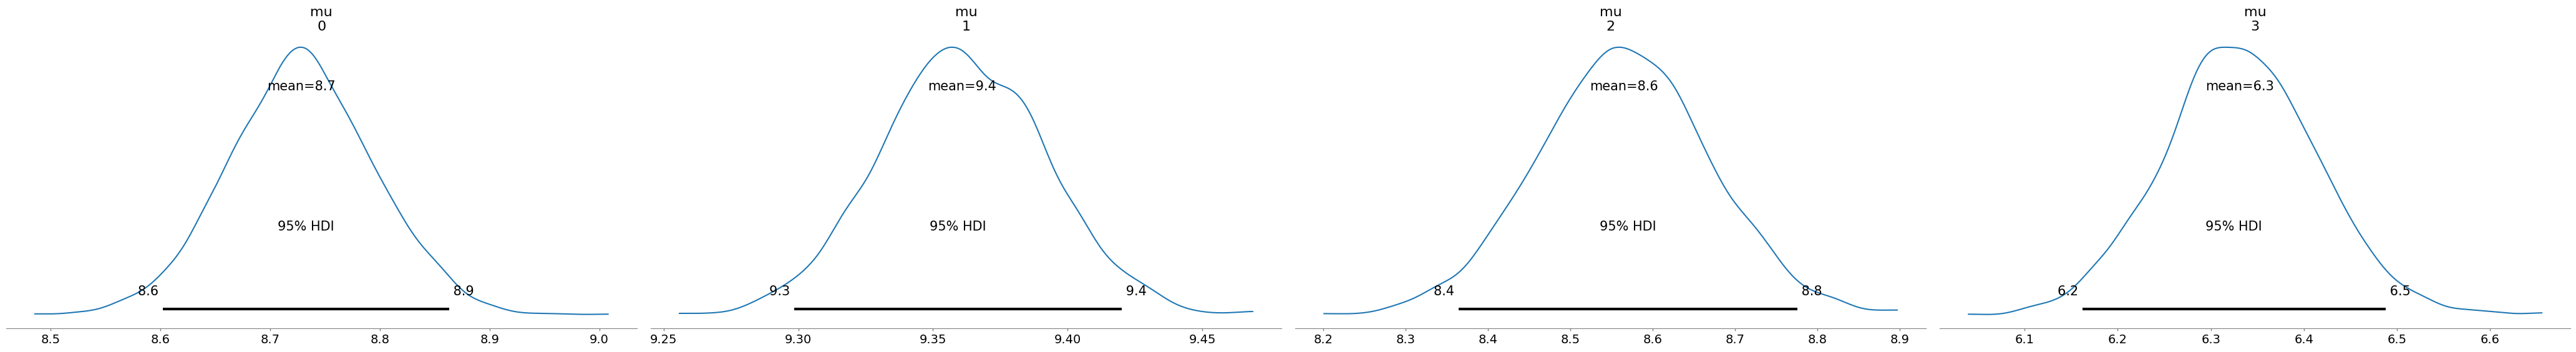

In [24]:
# Plotting 95% Credible Intervals for all the region's means
az.plot_posterior(trace_d.posterior["mu"], hdi_prob = 0.95)
plt.tight_layout()

In [25]:
# Storing 95% Credible Intervals for all the region's means in a dataframe
lower_ci = [8.6, 9.3, 8.4, 6.2]
upper_ci = [8.9, 9.4, 8.8, 6.5]

credible_intervals = pd.DataFrame({"Region": regions, "Lower Credible Interval": lower_ci, "Upper Credible Interval": upper_ci})
credible_intervals

,Region,Lower Credible Interval,Upper Credible Interval
0,Midwest,8.6,8.9
1,South,9.3,9.4
2,Northeast,8.4,8.8
3,West,6.2,6.5


# **GLMs**

Research Question: How well can state-level features like PM2.5 concentration, median income, unemployment rate, and other demographic features predict state-level crude prevalence of asthma, comparing GLMs and non-parametric methods?


### Data Wrangling

In [26]:
# Loading data
full_data = pd.read_csv("glm_final_dataset.csv", thousands = ',')
full_data = full_data.drop(columns = ["Unnamed: 0"])

# Fixing Data Types
full_data['adolescent_obesity'] = pd.to_numeric(full_data['adolescent_obesity'], errors = 'coerce')
full_data = full_data.astype({'adolescent_obesity':'float'})

# Converting prevalence percent column to proportion
full_data['asthma_crude_prevalence'] = full_data['asthma_crude_prevalence'] / 100
full_data.head()

,district_name,statefips,poverty_rate_all_ages,poverty_rate_0_to_17,median_income,adult_obesity,adolescent_obesity,ds_pm_pred,smoking_rate,asthma_crude_prevalence,region
0,Alabama,1,19.2,27.4,42917,33.5,17.1,10.628984,20.2,0.095,South
1,Alaska,2,11.4,15.5,70898,29.7,12.4,NaN,17.4,0.081,West
2,Arizona,4,18.2,25.6,50036,28.9,10.7,5.687440,14.9,0.096,West
3,Arkansas,5,18.7,26.3,41335,35.9,17.8,9.703796,20.2,0.088,South
4,California,6,16.4,22.6,61927,24.7,NaN,8.628624,10.0,0.078,West


In [27]:
# Checking to see which columns have nulls
full_data.isna().sum()

district_name              0
statefips                  0
poverty_rate_all_ages      0
poverty_rate_0_to_17       0
median_income              0
adult_obesity              0
adolescent_obesity         9
ds_pm_pred                 2
smoking_rate               1
asthma_crude_prevalence    0
region                     0
dtype: int64

From above, we see that we have null values for 3 columns. To determine whether imputating with the mean or median is more appropiate, we graphed the distribution of the data. We imputed adolescent_obesity with the median because the distribution of the data is right skewed. Meanwhile, we imputed smoking_rate and ss_pm_pred with the mean since the distribution of the data is symmetrical.

In [28]:
# Imputation

adolescent_obesity_median = np.nanmedian(full_data['adolescent_obesity'])
ds_pm_pred_mean = np.mean(full_data['ds_pm_pred'])
smoking_rate_mean = np.mean(full_data['smoking_rate'])

values = {"adolescent_obesity":adolescent_obesity_median,
          "ds_pm_pred":ds_pm_pred_mean,
          "smoking_rate":smoking_rate_mean}

imputed_data = full_data.fillna(value = values)

### GLMs EDA

In [29]:
# One Hot Encoding Region Column

ohe = OneHotEncoder(handle_unknown = 'ignore')
region_cat = imputed_data[['region']]
res = ohe.fit_transform(region_cat)
ohe_region = pd.DataFrame(res.toarray())
ohe_region.columns = ohe.get_feature_names_out(["region"])
ohe_region.head()

,region_Midwest,region_Northeast,region_South,region_West
0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0


In [30]:
np.random.seed(10)
X = imputed_data.drop(columns = ["district_name", "statefips", "asthma_crude_prevalence", "region",
                                  "median_income", "adult_obesity", "poverty_rate_0_to_17"]) # Only quantitative variables
X_ohe = pd.concat([X, ohe_region], axis = 1)
X_new = imputed_data[['smoking_rate', "ds_pm_pred", "adult_obesity"]]
y = imputed_data["asthma_crude_prevalence"]

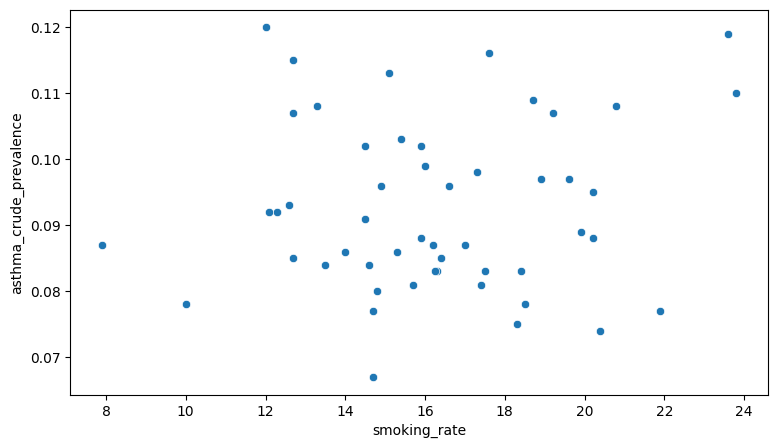

In [31]:
sns.scatterplot(x = imputed_data['smoking_rate'], y = imputed_data['asthma_crude_prevalence']);

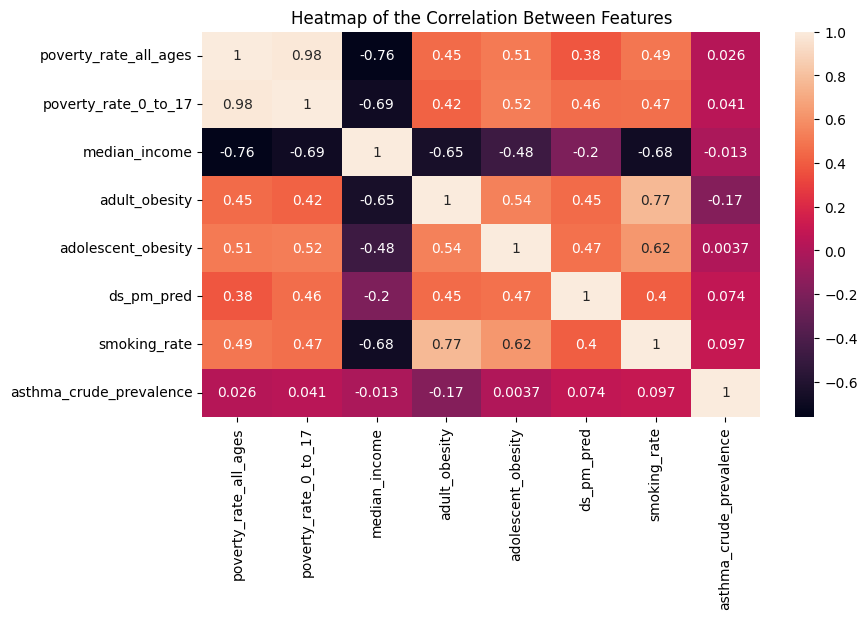

In [32]:
corr_data = imputed_data.drop(columns = ["district_name", "statefips", "region"])

# calculate the correlation matrix on the numeric columns
corr = corr_data.corr()

# plot the heatmap
sns.heatmap(corr, annot=True)
plt.title("Heatmap of the Correlation Between Features");

### GLMs

In [33]:
# Cross Validation for both models

gamma_errors = []
rf_errors = []
constant_errors = []

kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
for i, (train, test) in enumerate(kf.split(X_ohe)):

    # Training split
    X_train = X_ohe.loc[train]
    y_train = y.loc[train]

    # Test split
    X_test = X_ohe.loc[test]
    y_test = y.loc[test]

    # Gamma GLM Model
    gamma_model = sm.GLM(y_train, sm.add_constant(X_train), family = sm.families.Gamma(link=sm.families.links.log())).fit()
    gamma_preds = gamma_model.predict(sm.add_constant(X_test))
    gamma_errors.append(mean_squared_error(y_test, gamma_preds))

    # Random Forest Regression
    rf_model = RandomForestRegressor(n_estimators = 1000, max_depth = None, random_state = 43)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)
    rf_errors.append(mean_squared_error(y_test, rf_preds))

    # Constant model
    constant_pred = np.mean(y_train)
    constant_errors.append(mean_squared_error(y_test, np.repeat(constant_pred, len(y_test))))


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The 

In [34]:
print("RMSE of the Random Forest Regression Model: ", np.sqrt(np.mean(rf_errors)))
print("RMSE of the Constant Model: ", np.sqrt(np.mean(constant_errors)))
print("RMSE of the Gamma GLM Model: ", np.sqrt(np.mean(gamma_errors)))

RMSE of the Random Forest Regression Model:  0.012589481302550663
RMSE of the Constant Model:  0.012951406760560688
RMSE of the Gamma GLM Model:  0.012370087088364234


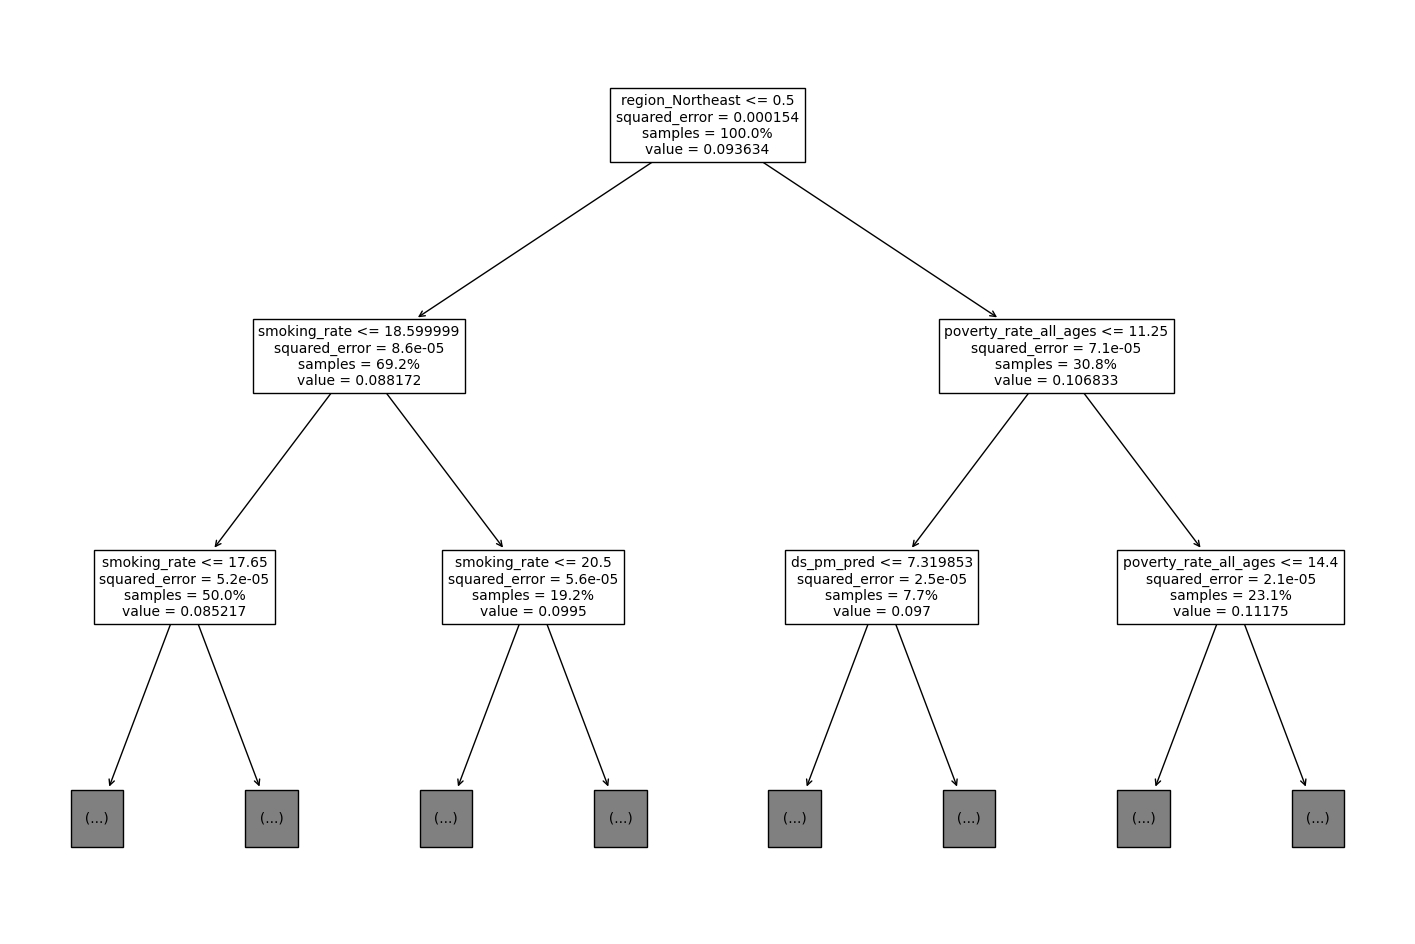

In [35]:
plt.figure(figsize=(18,12))  # set plot size (denoted in inches)
plot_tree(rf_model.estimators_[0], max_depth = 2, feature_names = rf_model.feature_names_in_, proportion = True,
           fontsize = 10, precision = 6);

In [36]:
gamma_model = sm.GLM(y, sm.add_constant(X_ohe), family = sm.families.Gamma(link=sm.families.links.log())).fit()
print(gamma_model.summary())

                    Generalized Linear Model Regression Results                    
Dep. Variable:     asthma_crude_prevalence   No. Observations:                   51
Model:                                 GLM   Df Residuals:                       43
Model Family:                        Gamma   Df Model:                            7
Link Function:                         log   Scale:                        0.014422
Method:                               IRLS   Log-Likelihood:                 161.31
Date:                     Sun, 05 May 2024   Deviance:                      0.62595
Time:                             20:09:31   Pearson chi2:                    0.620
No. Iterations:                          9   Pseudo R-squ. (CS):             0.3601
Covariance Type:                 nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [37]:
binomial_model = sm.GLM(y, sm.add_constant(X_ohe), family = sm.families.Binomial()).fit()
print(binomial_model.summary())

                    Generalized Linear Model Regression Results                    
Dep. Variable:     asthma_crude_prevalence   No. Observations:                   51
Model:                                 GLM   Df Residuals:                       43
Model Family:                     Binomial   Df Model:                            7
Link Function:                       Logit   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -11.489
Date:                     Sun, 05 May 2024   Deviance:                     0.063939
Time:                             20:09:31   Pearson chi2:                   0.0638
No. Iterations:                          5   Pseudo R-squ. (CS):          0.0006675
Covariance Type:                 nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [38]:
predictions = gamma_model.get_prediction(sm.add_constant(X_ohe))
res = predictions.summary_frame(alpha = 0.05)
res['true'] = y
res = res.sort_values(by = "mean").reset_index()

<ipython-input-39-10d31487422f>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot((i, i), (lower_bounds[i], upper_bounds[i]), 'ro-',


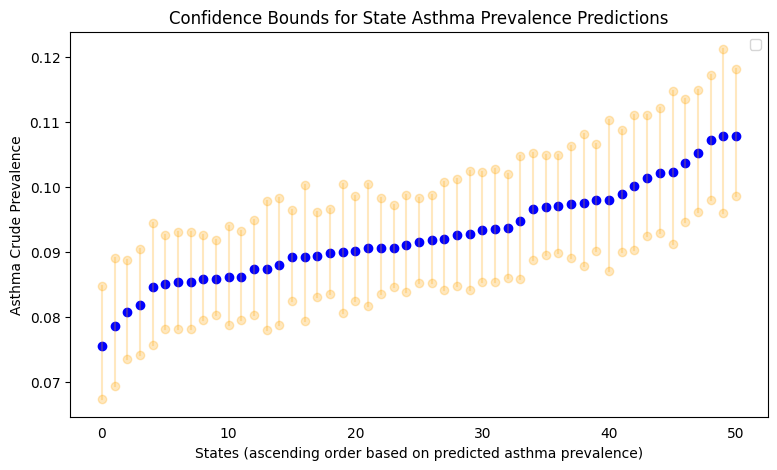

In [39]:
means = res['mean']
lower_bounds = res['mean_ci_lower']
upper_bounds = res['mean_ci_upper']

for i in range(len(means)):
    plt.scatter(i, means[i], color = "blue")
    plt.plot((i, i), (lower_bounds[i], upper_bounds[i]), 'ro-',
              color='orange', alpha = 0.25)

plt.title("Confidence Bounds for State Asthma Prevalence Predictions")
plt.xlabel("States (ascending order based on predicted asthma prevalence)")
plt.ylabel("Asthma Crude Prevalence");
plt.tick_params(axis = 'x', bottom = False)
plt.legend();

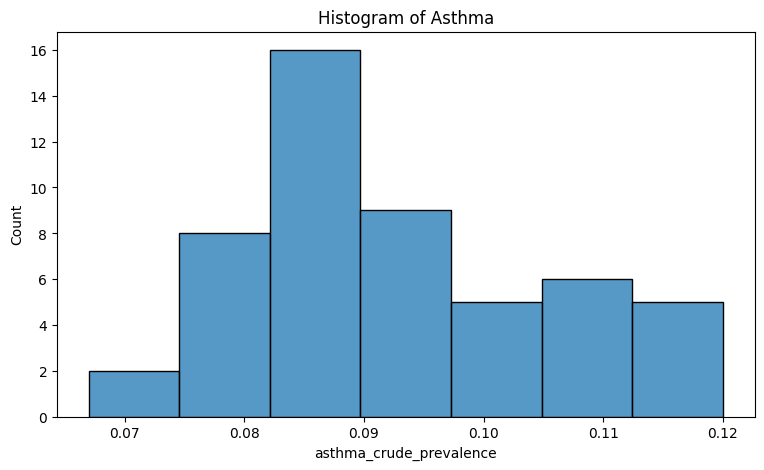

In [40]:
sns.histplot(imputed_data['asthma_crude_prevalence'])
plt.title("Histogram of Asthma");

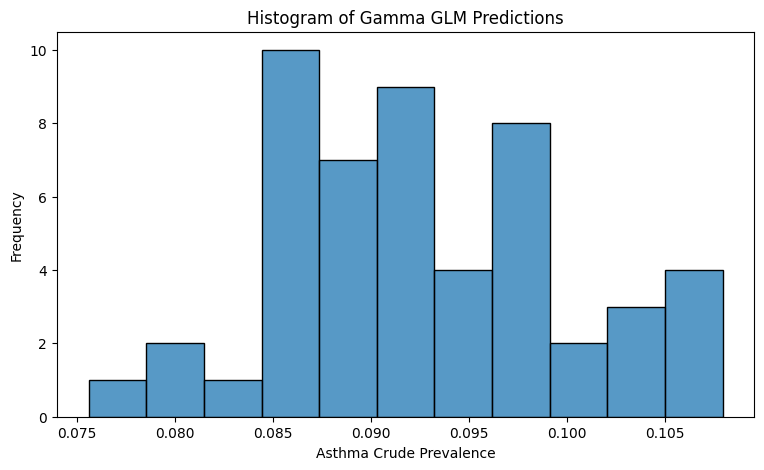

In [41]:
sns.histplot(gamma_model.predict(sm.add_constant(X_ohe)), bins = 11)
plt.title("Histogram of Gamma GLM Predictions")
plt.xlabel("Asthma Crude Prevalence")
plt.ylabel("Frequency");